# CCD Data Reduction: Part 1, darks & biases

In this notebook, we will go through the process of CCD data reduction for a fixed set of files.

Goals:

1. Learn how to load, examine, and visualize FITS files using astropy
2. Learn how to use python tools to estimate statistical parameters: mean (average), standard deviation
3. Practice using these python tools on both single files and data sets

# Index

 * [#1. Inspect Biases](#1.-Inspect-an-image:-Bias) - mostly guided work, you will run cells & read
   * [Show an image with improved contrast](#Show-an-image-with-improved-contrast)
   * [Zoom in on a hot pixel](#Zooming-in-on-a-hot-pixel) student exercise
   * [Examining Histograms](#Examining-Histograms)
   * [Masking](#Masking)
   * [Gaussian Distribution](#Gaussian-distribution)
   * [Noise Estimation](#Noise-Estimation)
   * [Header Loading](#Header-Loading-Aside) student exercise
   * [Multiple Exposures -> Time Series Cube](#Multiple-Exposures-as-a-"Time-Series"-Data-Cube)
   * [Mean of the Mean](#The-mean-of-the-mean)
   * [Robust Statistics](#Robust-Statistics)
 * [#2. Inspect Darks](#2.-Inspect-an-image:-Dark-Frame) - student work: you fill in the blanks
   * [Dark Frame Questions](#Dark-Frame-Questions)
   * [Dark Current Rate](#Dark-Current-Rate)
   * [vmin, vmax](#Student-Question:-vmin,-vmax)
   * [Bias-subtracted dark statistics](#Bias-subtracted-Dark-Stats)
   * [Noise estimate from dark stack](#Noise-estimate-from-dark-stack)
 * [#3. Image Inspection](#3.-Inspect-some-on-sky-data)

The first step is to get the data in the right place.  Running the following cell will show you where you are.  `os` stands for "operating system", and `getcwd` is short for "get current working directory"

In [1]:
import os
print(os.getcwd())

Download your FITS files from the Canvas page and move them to the directory above.  You can do this using either the filesystem tools for your OS (e.g., Finder on mac, Windows Explorer on windows), or you can do it directly here.  For example, you might do:

```
%%bash
mv ~/Downloads/*.FIT . 
```

to move all files from your `~/Downloads` directory to the current directory (`.` and `cwd` are shorthand for the current working directory).  

Note that `~` is shorthand for your user directory, e.g., `/Users/adam` on Mac or `C:\Users\adam` on Windows.  

`*` is a wildcard that matches anything.

Verify that the expected files are all here using `ls *.FIT`.  You should see 11 bias files, `bias_00[1-9].FIT` & `bias_010.FIT`, and 30 dark files, `dark_10s_0[0-3][0-9].FIT`:

In [2]:
import glob
glob.glob("*.FIT")

['bias_001.FIT',
 'bias_002.FIT',
 'bias_003.FIT',
 'bias_004.FIT',
 'bias_005.FIT',
 'bias_006.FIT',
 'bias_007.FIT',
 'bias_008.FIT',
 'bias_009.FIT',
 'bias_010.FIT',
 'dark_10s_001.FIT',
 'dark_10s_002.FIT',
 'dark_10s_003.FIT',
 'dark_10s_004.FIT',
 'dark_10s_005.FIT',
 'dark_10s_006.FIT',
 'dark_10s_007.FIT',
 'dark_10s_008.FIT',
 'dark_10s_009.FIT',
 'dark_10s_010.FIT',
 'dark_10s_011.FIT',
 'dark_10s_012.FIT',
 'dark_10s_013.FIT',
 'dark_10s_014.FIT',
 'dark_10s_015.FIT',
 'dark_10s_016.FIT',
 'dark_10s_017.FIT',
 'dark_10s_018.FIT',
 'dark_10s_019.FIT',
 'dark_10s_020.FIT',
 'dark_10s_021.FIT',
 'dark_10s_022.FIT',
 'dark_10s_023.FIT',
 'dark_10s_024.FIT',
 'dark_10s_025.FIT',
 'dark_10s_026.FIT',
 'dark_10s_027.FIT',
 'dark_10s_028.FIT',
 'dark_10s_029.FIT',
 'target_image.FIT']

# 1. Inspect an image: Bias

The first step is to look at an image and see what it contains.  We do this using [astropy's FITS reader](https://docs.astropy.org/en/stable/io/fits/) and matplotlib ([example](http://learn.astropy.org/rst-tutorials/FITS-images.html)).

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower' # this is needed to have 0,0 in the lower left
plt.rcParams['image.interpolation'] = 'none' # this makes pixels less blurry
# OPTIONAL: if you want to use a different stylesheet, use this line:
#plt.style.use('dark_background')
from astropy.io import fits

In [4]:
bias_fn = 'bias_001.FIT'
data = fits.getdata(bias_fn)

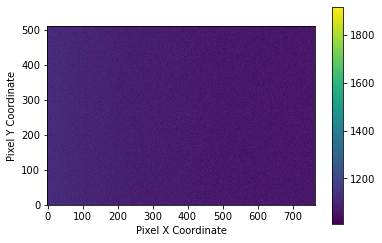

In [5]:
plt.imshow(data)
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

Simply showing the image isn't enough, we also need to scale it so that there is reasonable contrast within the image, and we'd like it to be big enough that we can see each pixel clearly.

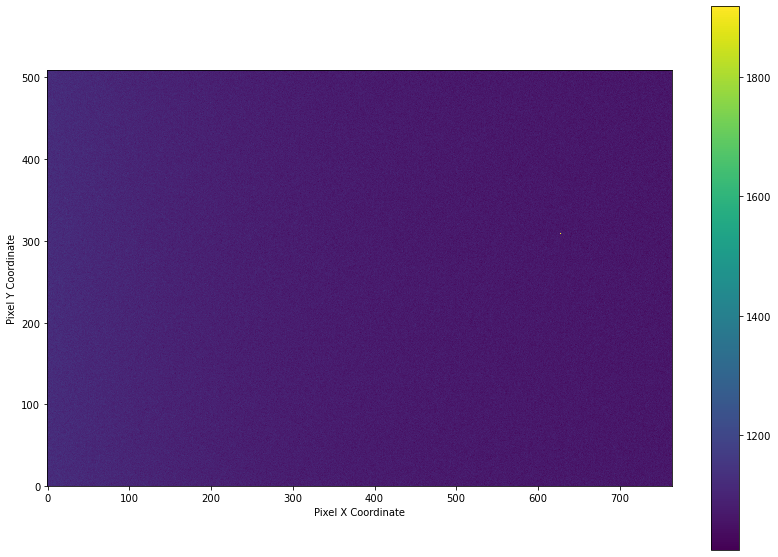

In [6]:
plt.figure(figsize=(14,10))
plt.imshow(data)
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

## Show an image with improved contrast

[Index](#Index)

The astropy visualization toolkit helps us improve the contrast by using a different data stretch.

In [7]:
from astropy import visualization

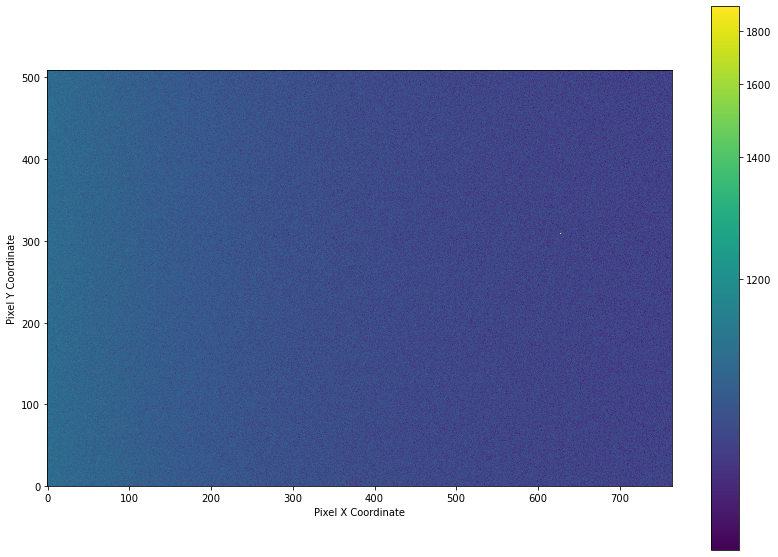

In [8]:
plt.figure(figsize=(14,10))
plt.imshow(data, norm=visualization.simple_norm(data, stretch='asinh'))
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

There are two notable features in this image:
1. There is a gradient from left to right, with the left being brighter.
2. There is a hot pixel.  How can we identify it?

### Zooming in on a hot pixel

[Index](#Index)


Since it's the brightest pixel in the image, we can simply find the maximum value, and then find out where that maximum value is:

In [9]:
print("Brightest value:", data.max())
print("Location of brightest value:", data.argmax())

Brightest value: 1918
Location of brightest value: 236248


You'll note that the pixel number above is in the 100,000's, but our image is only 765x510 (numpy arrays use reverse-ordered indexing, so it is (y,x) instead of (x,y)):

In [10]:
data.shape

(510, 765)

That coordinate, 236248, is telling you that the brightest pixel is the 236248th pixel, in order, if you lay out the whole array in a line. But, we want to know where that pixel is in two dimensions, not one.

To find the location in x,y coordinates, we use a numpy tool:

In [11]:
import numpy as np

In [12]:
print("y,x coordinates of the brightest pixel:", np.unravel_index(data.argmax(), data.shape))

y,x coordinates of the brightest pixel: (308, 628)


Describe in your own words: what did `unravel_index` do?

it ravles
it takes the one dimensional data to show us a 2d point of where the hot pixel is 


We can then "zoom in" to that part of the image by "slicing" out a chunk of the `data` array:

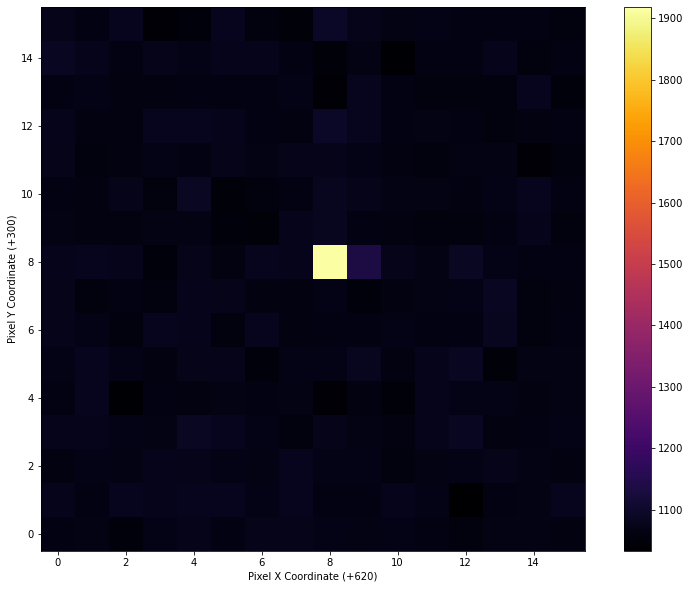

In [13]:
plt.figure(figsize=(14,10))
# we pick a "slice" from (y-8) to (y+8) and from (x-8) to (x+8)
plt.imshow(data[300:316, 620:636], cmap='inferno')
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate (+620)")
_=plt.ylabel("Pixel Y Coordinate (+300)")

### Examining Histograms

[Index](#Index)

We need to know something about the _distribution_ of pixel brightnesses beyond just where they are.  We can look at this distribution using a histogram.

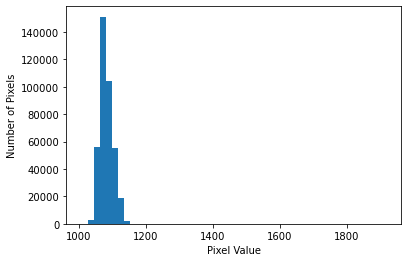

In [14]:
# the "ravel" method turns the 2D data image into a 1D list of values.
# we use it here because of the syntax requirements of the `hist` function
histresult = plt.hist(data.ravel(), bins=50)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

Note that the above histogram shows a broad range along the X-axis, but most of the pixels are in a narrow range.  The hot pixel is an _outlier_ from this distribution.

We can see this more clearly by log-scaling the histogram

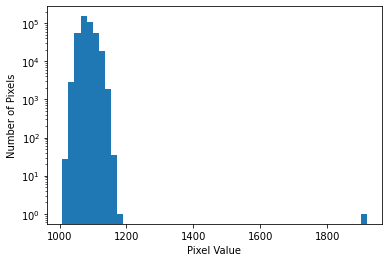

In [15]:
histresult = plt.hist(data.ravel(), bins=50, log=True)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

We can re-make this histogram excluding the outlier using a "masking" approach.

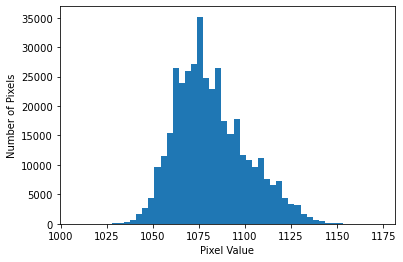

In [16]:
# first, we create a mask that excludes the bad data
# this is a "boolean array" of True and False values
# it will be True everywhere except on the one hot pixel, where it will be False
mask = data < 1800
# then, we re-histogram selecting the "good" data
histresult = plt.hist(data[mask].ravel(), bins=50)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

### Masking

[Index](#Index)

What did that line, `mask = data < 1800` do exactly?  It created a new array in which the number of pixels are the same as in ``data``, but now each pixel has a value of either True or False.

We can look at the mask, and see that it is mostly True (`True` will be yellow, `False` will be purple, by default).  You should be able to see one purple pixel at least:

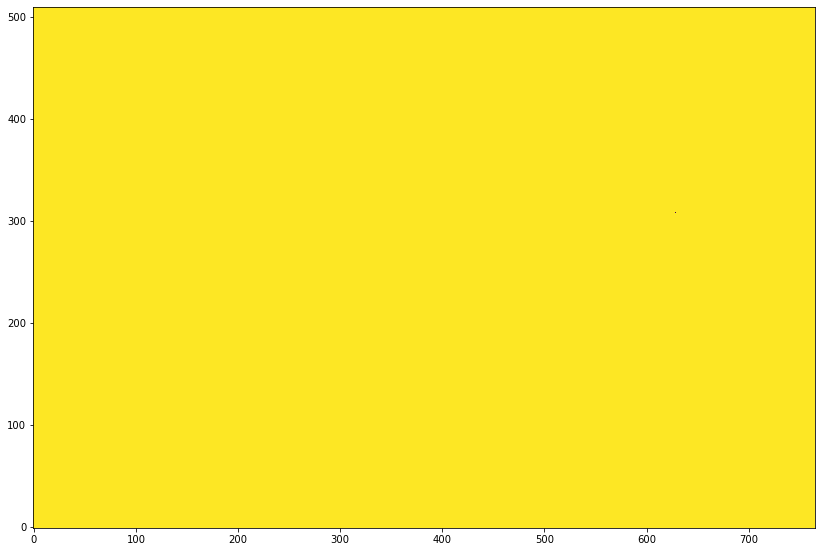

In [17]:
plt.figure(figsize=(14,14))
plt.imshow(mask)

When we index the data with `data[mask]`, we get back an array that includes the pixel value if the mask was `True` at that pixel, and does not include the pixel value if the mask was `False` at that pixel.

We can "invert the mask" and switch True to False and False to True with the `~` operator.  This lets us see the value of our outlier (in this case, there's only one):

In [18]:
data[~mask]

array([1918], dtype=uint16)

## Gaussian distribution

[Index](#Index)


Our bias image has a gradient in it, as you could see above, so its noise distribution does not look like a Gaussian.   Instead, it has a tail.  We can see this by over-plotting a Gaussian function with a reasonable estimate for the location parameters.

The Gaussian function is:

$$
f(x) = \frac{1}{\sigma \sqrt{2 \pi }} e^{-(x-x_0)^2 / (2 \sigma^2)}
$$

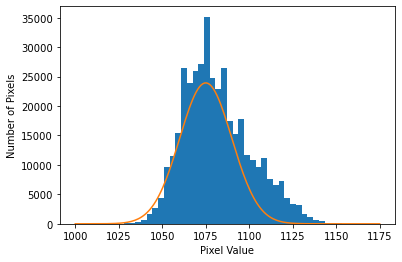

In [19]:
# this part repeats the histogram-making above
mask = data < 1800
histresult = plt.hist(data[mask].ravel(), bins=50)

# 'linspace' makes an array of (175) evenly-spaced points from the lower (1000) to upper (1175) value
x = np.linspace(1000, 1175, 175)
sigma = 15 # I guessed this value by eye
x0 = 1075 # I guessed this too
# compute the Gaussian function:
y = 1/(sigma*(2*np.pi)**0.5) * np.exp(-(x-x0)**2/(2*sigma**2))
scale = 900000 # we need to multiply by a scale factor to see the curve; this number is arbitrary
plt.plot(x, y*scale)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

You can see from the above curve that there is something like a "skewed Gaussian" distribution in the data: the Gaussian curve fits most of the data, but there's a tail out to the right side.

Because of this tail, our noise estimates on the data won't be exactly right, but we can make them anyway.

### Noise Estimation

[Index](#Index)

We estimate the noise by taking the _standard deviation_ of the data.  If the bias were uniform, the standard deviation of our image would represent a measurement of the _read noise_ plus the intrinsic pixel-to-pixel variation.  If the pixel-to-pixel variation is small, the read noise would then be the only contributor to the measurement.

(`ddof` is the degrees of freedom.  This is a statistical correction for the fact that we're estimating the mean and the variation around the mean from the same data)

In [20]:
print("Estimated read noise + pixel-to-pixel variation (without accounting for gradient):", data[mask].std(ddof=1))

Estimated read noise + pixel-to-pixel variation (without accounting for gradient): 19.314968369832094


The `std` method gives us the standard deviation of the data, and it suggests that the noise is about 19 counts.

However, now we need to explore another way to estimate the readnoise.

We have many bias images.  We can combine them to obtain a direct estimate of the readnoise, independent of the pixel-to-pixel variation.

Each bias image is the same.  The only difference between the images will be read noise.  That means we can estimate the noise on a pixel-by-pixel basis, but by comparing each pixel to itself over many measurements.

We start by verifying that our bias images are all taken under the same conditions.  We can do this by looking at their FITS headers to make sure they have the same exposure time.

In [21]:
# the "glob" module lets us store the results of wildcard searches into python variables
import glob
bias_file_list = glob.glob("bias*FIT")
print("There are",len(bias_file_list),"bias images")
print(bias_file_list)

There are 10 bias images
['bias_001.FIT', 'bias_002.FIT', 'bias_003.FIT', 'bias_004.FIT', 'bias_005.FIT', 'bias_006.FIT', 'bias_007.FIT', 'bias_008.FIT', 'bias_009.FIT', 'bias_010.FIT']


We use `for` loops to loop over the entries in a list.  This example will print relevant information - the exposure time and CCD temperature - for each "bias" image.

In [22]:
for filename in bias_file_list:
    header = fits.getheader(filename)
    print(filename, header['EXPTIME'], header['CCD-TEMP'])

bias_001.FIT 0.04 -4.817803680962
bias_002.FIT 0.04 -4.817803680962
bias_003.FIT 0.04 -4.817803680962
bias_004.FIT 0.04 -4.817803680962
bias_005.FIT 0.04 -4.817803680962
bias_006.FIT 0.04 -4.817803680962
bias_007.FIT 0.04 -4.817803680962
bias_008.FIT 0.04 -4.817803680962
bias_009.FIT 0.04 -4.817803680962
bias_010.FIT 0.04 -4.817803680962


By inspecting the headers above, we see that we have 10 bias images to work with.

Note that these "bias" images are not strictly bias images; they are technically 0.04 second Dark frames.  In 0.04 seconds, we probably will not accrue much dark current, but there might be some small dark current contribution.

#### Header Loading Aside

[Index](#Index)

(aside: how do we inspect headers?  How did I know to use the `'EXPTIME'` keyword?  `fits.getheader` loads a header from a file.  In the cell below, load a header from any file and see what it looks like:)

In [23]:
# STUDENT ACTIVITY:
# Use `fits.getheader` to read the header from a .FIT file and show the header contents

dark_fnnn  = 'dark_10s_007.FIT'
header = fits.getheader(dark_fnnn)
header

SIMPLE  =                    T /                                                
BITPIX  =                   16 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                  765 /                                                
NAXIS2  =                  510 /                                                
OBJECT  = '        '           /                                                
TELESCOP= 'Unknown Telescope'                                                   
INSTRUME= 'SBIG ST-402'                                                         
OBSERVER= 'Observer's Name'                                                     
DATE-OBS= '2020-01-16T02:15:19.000' / GMT START OF EXPOSURE [WIN]               
BZERO   = +3.276800000000E+004 /                                                
BSCALE  = +1.000000000000E+000 /                                                
EXPTIME = +1.000000000000E+0

Because these came from the same CCD, they all have the same dimensions.


## Multiple Exposures as a "Time Series" Data Cube

[Index](#Index)

We can therefore stack up their data into a "data cube" that will effectively be a time series: two dimensions are pixel dimensions (x, y), while the third (z) is time; we took each image at a different time, and that's the only thing that changed.

In [24]:
# the `fits.getdata` function loads data from a fits file
# np.array() converts an input to an array
# the "inline for loop" is the really important part here, though:
# we are loading one image for each file name in the bias_file_list we made above
bias_timeseries = np.array([fits.getdata(fn) for fn in bias_file_list])

In [25]:
print(bias_timeseries.shape)

(10, 510, 765)


The data structure `bias_timeseries` is now an array of ten images that are each the same size.

We can perform statistics along the time axis (the array is in `z,y,x` shape, so `z` is the time axis).  To see what this means, we can look at what the time series data looks like for a single pixel.

In the example below, we plot the time series for pixel x=150, y=100:

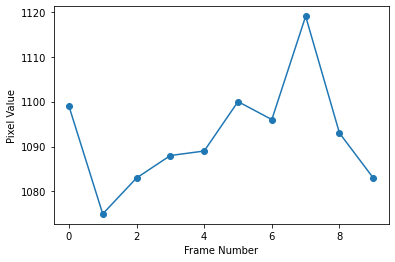

In [26]:
_=plt.plot(bias_timeseries[:,100,150], marker='o')
_=plt.xlabel("Frame Number")
_=plt.ylabel("Pixel Value")

We can take statistics of this pixel to see what the mean and standard deviation are:

In [27]:
print("Mean =",bias_timeseries[:,100,150].mean(), " Standard deviation =",bias_timeseries[:,100,150].std(ddof=1))

Mean = 1092.5  Standard deviation = 12.167808165629319


So we see that our bias is about 1092.5 +/- 12.2 counts.

To repeat this measurement for _every_ pixel, we obtain the statistics along an axis:

In [28]:
bias_mean_image = bias_timeseries.mean(axis=0)
bias_std_image = bias_timeseries.std(axis=0, ddof=1)

Take a moment to appreciate the above line.  It just did a _lot_ of things all at once:

* it calculated the mean of 10 exposures for each of 765 * 510 = 390150 pixels
* it calculated the standard deviation of 10 exposures for each pixel
* it stored the results of each into an image array of the same shape as the inputs

This array arithmetic - doing the same operations on millions of pixels all at once - is at the heart of image analysis.  Computers can do this sort of thing very fast, and they have to.

We then inspect these as images, as before.  The mean image looks just like the original data image:

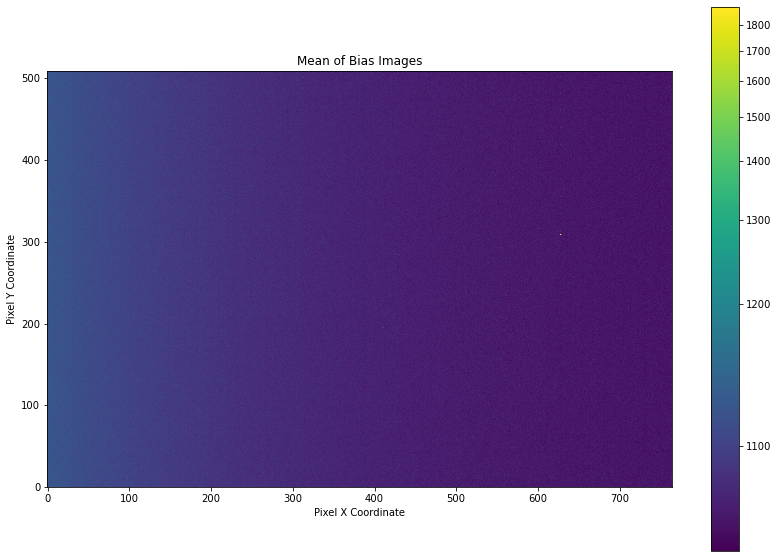

In [29]:
plt.figure(figsize=(14,10))
plt.imshow(bias_mean_image, norm=visualization.simple_norm(bias_mean_image, stretch='asinh'))
plt.colorbar()
_=plt.title("Mean of Bias Images")
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

However, the standard deviation image looks quite different: it's now nearly the same everywhere, the only thing left in the image is (read) noise:

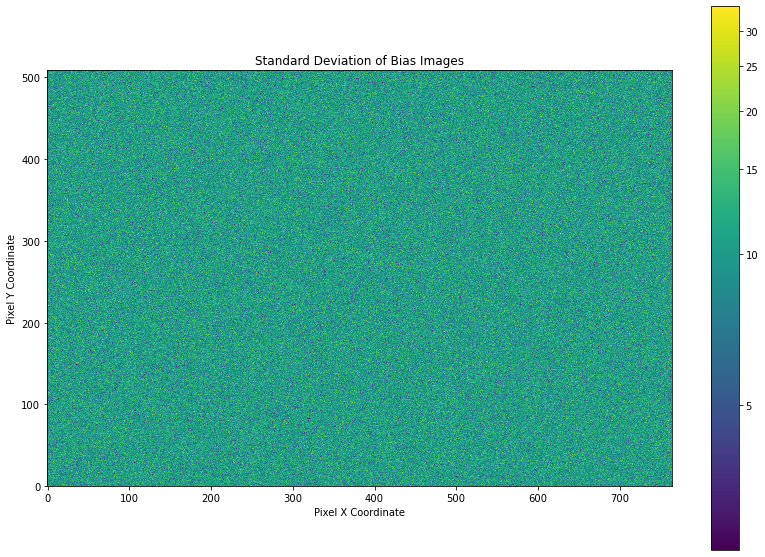

In [30]:
plt.figure(figsize=(14,10))
plt.imshow(bias_std_image, norm=visualization.simple_norm(bias_std_image, stretch='asinh'))
plt.colorbar()
_=plt.title("Standard Deviation of Bias Images")
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

Each value in the `bias_std_image` map is an independent measurement of the read noise from the detector.  Let's look at some values, including our x,y=150,100 and at the hot pixel:

In [31]:
print("Estimate of read noise at 150,100:",bias_std_image[100,150],"and at y,x=(308, 628)", bias_std_image[308,628])

Estimate of read noise at 150,100: 12.167808165629319 and at y,x=(308, 628) 34.066764513884266


## The mean of the mean

[Index](#Index)

To get the best estimate of the average read noise, we can take the average *over all pixels* of our standard deviation *measured across time samples*:

In [32]:
mean_readnoise = bias_std_image.mean()
print("The mean readnoise over all pixels =",mean_readnoise)

The mean readnoise over all pixels = 10.557842457849686


Similarly, we can compute the average bias (again, averaging over all pixels in the CCD):

In [33]:
mean_bias = bias_mean_image.mean()
print("mean bias =",mean_bias)

mean bias = 1080.116577213892


So we have obtained an average bias of 1080 and an average read noise of 10.6.

## Robust Statistics

[Index](#Index)


However, the distribution function shown above was a _skewed_ Gaussian, which means our estimate of the mean and standard deviation are biased.  To account for such issues, we can employ _robust statistics_ to obtain better estimates.  "Robust statistics" are statitical estimates that are robust against outliers, i.e., adding in a few outliers does not substantially affect the estimate.

One example robust estimator is the _median_, which is very good at approximating the _mean_:

In [34]:
median_bias = np.median(bias_mean_image)
print("Median bias level across the image =",median_bias)
median_readnoise = np.median(bias_std_image)
print("Median standard deviation level across the image =",median_readnoise)

Median bias level across the image = 1074.9
Median standard deviation level across the image = 10.429125882194858


We can look at the histogram of the read noise estimates (`bias_std_image`).  In this case, they are very similar:

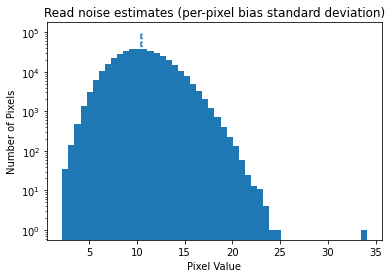

In [35]:
histresult = plt.hist(bias_std_image.ravel(), bins=50, log=True)
# plot a vertical line at the median, then at the mean
plt.vlines(median_readnoise, 1, 1e5, linestyle='--')
plt.vlines(mean_readnoise, 1, 1e5, linestyle=':')
plt.title("Read noise estimates (per-pixel bias standard deviation)")
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

For the bias value, the mean and median are quite different: the pixels are not "unimodel", they have a broad, non-Gaussian distribution.

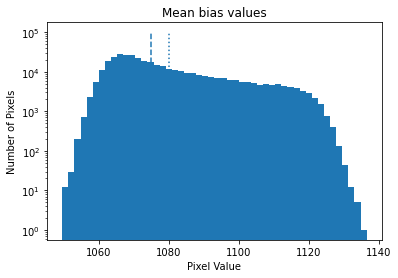

In [36]:
# we will re-make the mask we used to exclude outliers
mask = bias_mean_image < 1800
histresult = plt.hist(bias_mean_image[mask], bins=50, log=True)
# plot a vertical line at the median, then at the mean
plt.vlines(median_bias, 1, 1e5, linestyle='--')
plt.vlines(mean_bias, 1, 1e5, linestyle=':')
plt.title("Mean bias values")
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

# 2. Inspect an image: Dark Frame

[Index](#Index)

Next, we will look at our dark frames and see how they differ from the bias frames.

In [37]:
# student entry here: first, load the data
# Start with the first 10s dark image
dark_fn = 'dark_10s_001.FIT' # put a filename in the quotes
dark_data = fits.getdata(dark_fn) # then, load a FITS file's data as you've done above for the bias

# note:your answers should be something like:
# dark_fn = 'some_fits_fits.fits'
# dark_data = some_function_to_get_fits_data(dark_fn)
# in other words, use the variable dark_fn

In the next cell, show the image as we did [above](#Show-an-image-with-improved-contrast) for the bias.

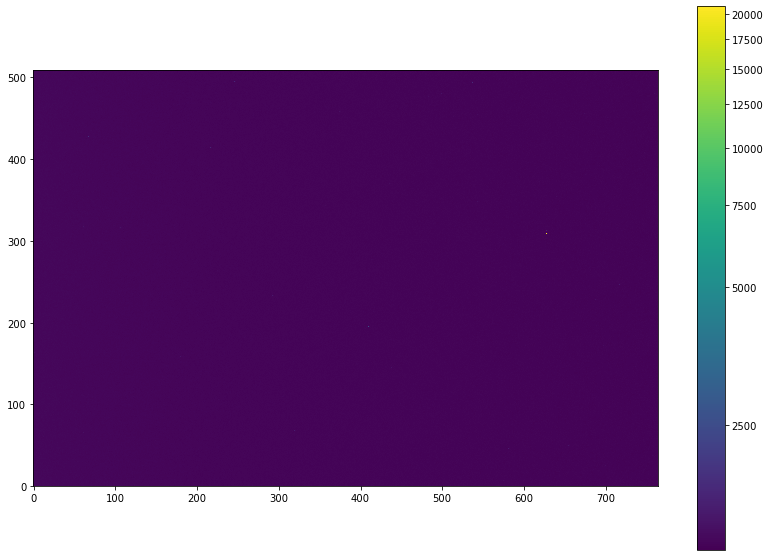

In [38]:
# student entry here
# then, display the data, just as with the bias above
plt.figure(figsize=(14,10))
plt.imshow(dark_data, norm=visualization.simple_norm(dark_data, stretch='asinh'))
plt.colorbar()

## Dark Frame Questions
[Index](#Index)

Use the code examples you saw above to answer these questions in the cells below

1. Is there a hot pixel?  Where is it?  
2. How long was the exposure?  Is the filename correct or misleading?
3. What is the average value in our dark frame?
4. What is the average dark current rate?  Note that you have to subtract the average bias to determine this.  You should use the _average_ dark current and _average_ bias for this.

Brightest value: 1918
Location of brightest value: 236248
(510, 765)
y,x coordinates of the brightest pixel: (308, 628)


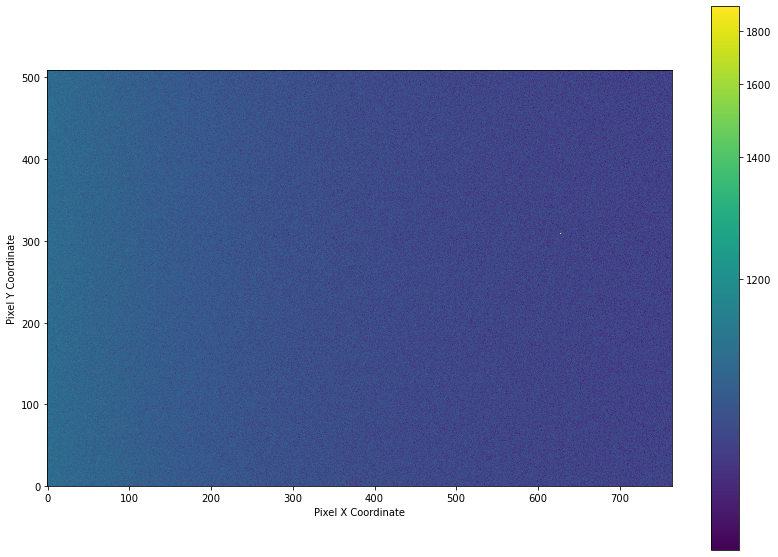

In [39]:
# student exercise: find the hot pixel (again, as done above for the bias image)

# Improve contrast
plt.figure(figsize=(14,10))
plt.imshow(data, norm=visualization.simple_norm(data, stretch='asinh'))
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

print("Brightest value:", data.max())
print("Location of brightest value:", data.argmax())
print(data.shape)

print("y,x coordinates of the brightest pixel:", np.unravel_index(data.argmax(), data.shape))


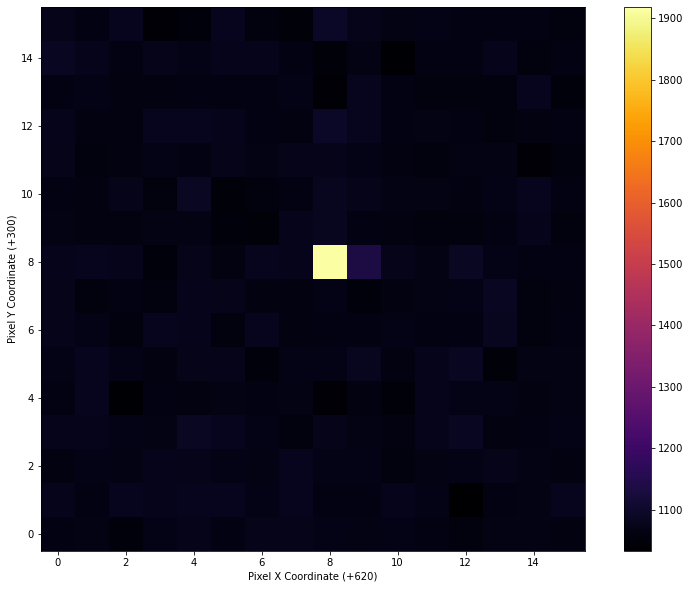

In [40]:
# zoom in on hot pixle 

plt.figure(figsize=(14,10))
# we pick a "slice" from (y-8) to (y+8) and from (x-8) to (x+8)
plt.imshow(data[300:316, 620:636], cmap='inferno')
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate (+620)")
_=plt.ylabel("Pixel Y Coordinate (+300)")

In [41]:
# student exercise: find the exposure time from the FITS header
# reminder: delete the <s and >s
header = fits.getheader(dark_fn)
print("The exposure time of dark_10s_001.FIT is", header['EXPTIME'])

The exposure time of dark_10s_001.FIT is 10.0


In [42]:
# student exercise: take the mean and median of the dark frame you loaded a minute ago
# (from above, the dark frame's data should be in the variable `dark_data`)

mean_dark = dark_data.mean()
print("Mean value =",mean_dark)

median_dark = np.median(dark_data)
print("Median value =",median_dark)

Mean value = 1095.2488222478535
Median value = 1092.0


You should get these values:

 * Mean value = 1095.2488222478535
 * Median value = 1092.0

1. Is there a hot pixel?  Where is it?  
Yes there is a hot pixel at (308, 628)
2. How long was the exposure?  Is the filename correct or misleading?
The exposure was 10 seconds, the file name is correct
3. What is the average value in our dark frame?
1095.248
4. What is the average dark current rate?  Note that you have to subtract the average bias to determine this.  You should use the _average_ dark current and _average_ bias for this.


## Dark Current Rate
[Index](#Index)

In the next cell, you'll estimate the _rate_ of dark current accumulation.

A rate is simply a number per time, so you need to calculate the number of dark counts and the exposure time.

Dividing them will get you the dark rate.

In [1]:
# student exercise: Determine the dark current and dark current rate
# the goal is to use the values computed above (the mean dark current and the mean bias)
# to obtain an estimate of the mean dark current and dark current rate

avg_dark_current = mean_dark - mean_bias
print(avg_dark_current)

avg_dark_rate = avg_dark_current / 10
print(avg_dark_rate)
#print("Dark current counts =", <your answer here>)
#print("Dark rate (dark current / exposure time) =", <your answer here>, "counts per second")

NameError: name 'mean_dark' is not defined

You should get:

 * Average dark current counts = 15.132245033961453
 * Average dark rate = 1.5132245033961453 counts per second

In the above exercise, you estimated the average dark current from the data.  However, we can do better by subtracting the bias pixel-by-pixel first.

Let's start by seeing what the bias-subtracted dark looks like.  As long as the images are the same `shape` (which is always true if they come from the same CCD), we can subtract them from one another.

The next several cells make images and guide you through some detailed image analysis.

In [44]:
# Subtract two images
# this means we will subtract each pixel's value in `bias_mean_image` from the corresponding value in `dark_data`
bias_subtracted_dark = dark_data - bias_mean_image

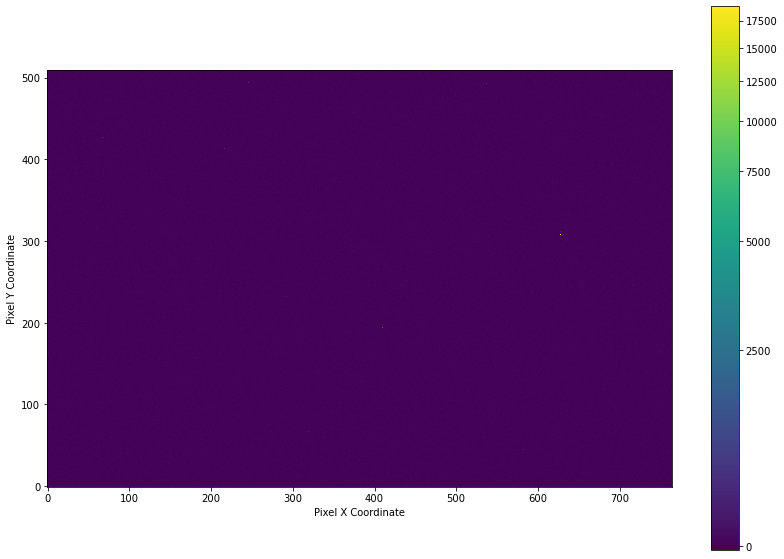

In [45]:
plt.figure(figsize=(14,10))
plt.imshow(bias_subtracted_dark, norm=visualization.simple_norm(bias_subtracted_dark, stretch='asinh'))
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

In the image above, we still have a pesky very bright outlier that is making our display look bad. 


To fix this, we need to know something about the _distribution_ of our data again

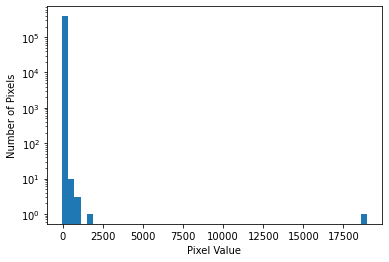

In [46]:
histresult = plt.hist(bias_subtracted_dark.ravel(), bins=50, log=True)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

From the above plot, we can see that _almost_ all of the data are in the range [0,2000], but there's that one big outlier.  In fact, the vast majority of the data are below, say, 100.  Let's mask out the bad pixel and look closer.

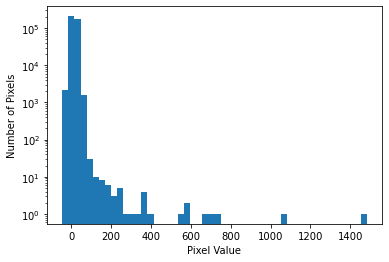

In [47]:
mask = bias_subtracted_dark < 8000
histresult = plt.hist(bias_subtracted_dark[mask].ravel(), bins=50, log=True)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

This new histogram, excluding our dramatic outlier, shows us that almost all of the data are below 200 counts.  We have only about 10-20 outliers above 200 (recall that $10^0 = 1$).  So let's zoom in once more:

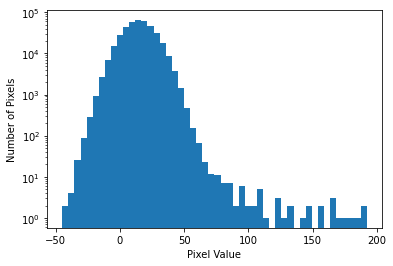

In [48]:
mask = bias_subtracted_dark < 200
histresult = plt.hist(bias_subtracted_dark[mask].ravel(), bins=50, log=True)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

The above plot is a well-behaved, Gaussian-looking distribution with a small tail, which we can see if we plot it with a linear Y-axis again:

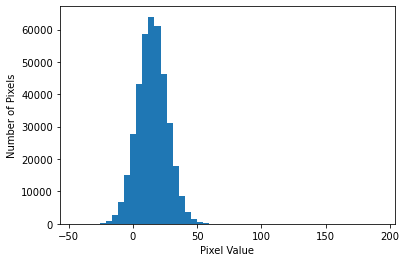

In [49]:
mask = bias_subtracted_dark < 200
histresult = plt.hist(bias_subtracted_dark[mask].ravel(), bins=50)
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

We can now display the image with a more reasonable range of values.  I picked -30 to 50, as they're pretty close to the boundaries of where we expect to see any pixels: there are only a couple pixels above and below these values.

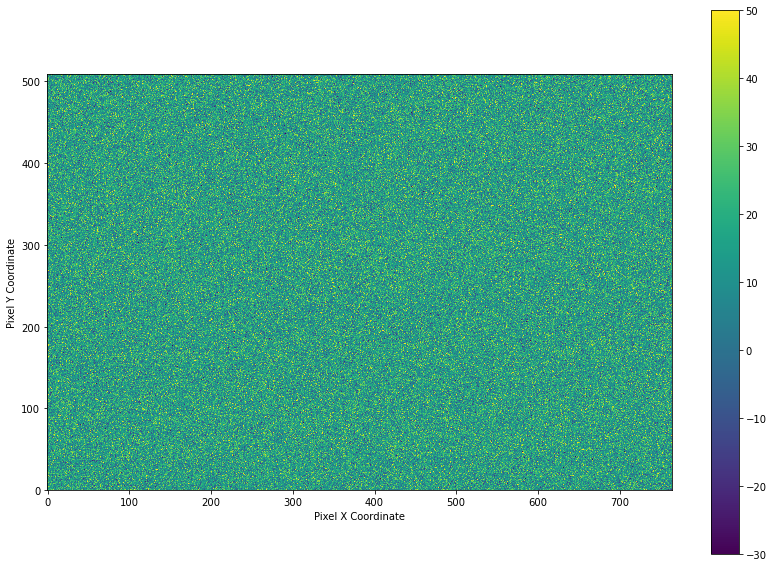

In [50]:
plt.figure(figsize=(14,10))
plt.imshow(bias_subtracted_dark, vmin=-30, vmax=50)
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

In [51]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)
    Display data as an image, i.e., on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. For displaying a grayscale
    image set up the color mapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    The number of pixels used to render an image is set by the axes size
    and the *dpi* of the figure. This can lead to aliasing artifacts when
    the image is resampled because the displayed image size will usually
    not match the size of *X* (see
    :doc:`/gallery/images_contours_and_fields/image_antialiasing`).
    The resampling can be controlled via the *interpolation* parameter
    and/or :rc:`image.interpolation`

### Student Question: vmin, vmax
[Index](#Index)

What do the `imshow` arguments `vmin` and `vmax` do?

`<vmin and vmax show the datarange that the colormap covers. The graph above shows for range 30 to 50 >`

Now we can see that the above image is a clean-looking noise frame.  There are a few outliers, but the mean value is constant across the image - there is no gradient.

Since we saw a gradient in the bias image, but we don't see one in the dark minus bias image, we can infer that the gradient is in the bias - in other words, it's intrinsic to our CCD and will always be there no matter how short an exposure we take.

## Bias-subtracted Dark Stats
[Index](#Index)

Now we can compute some statistics about this bias-subtracted dark image.  

What are the mean and median?

In [52]:
# student exercise: compute the mean and median of the bias-subtracted-dark
#bias_subtracted_dark

mean_bias_sub_dark = bias_subtracted_dark.mean()

median_bias_sub_dark = np.median(bias_subtracted_dark)

print("Mean bias_subtracted_dark =", mean_bias_sub_dark)
print("Median bias_subtracted_dark =", median_bias_sub_dark)

Mean bias_subtracted_dark = 15.132245033961297
Median bias_subtracted_dark = 15.0


You should get:

* Mean bias_subtracted_dark = 15.132245033961297
* Median bias_subtracted_dark = 15.0

These values are an estimate of the dark current obtained in this exposure, but they're a little different from the estimate obtained taking the mean of the dark minus the mean of the bias.

What is the estimated dark current rate (counts per second) for these data?

In [53]:
# student exercise: What is the dark current rate estimated after bias subtraction?

sub_avg_dark_rate = mean_bias_sub_dark  / 10

print("Rate estimate =",sub_avg_dark_rate)

Rate estimate = 1.5132245033961298


We can improve on this rate estimate by averaging over several dark images, like we did above with bias images.

In [54]:
dark_file_list = glob.glob("dark_10s*FIT")
print("There are",len(dark_file_list),"dark images")
print(dark_file_list)

There are 29 dark images
['dark_10s_001.FIT', 'dark_10s_002.FIT', 'dark_10s_003.FIT', 'dark_10s_004.FIT', 'dark_10s_005.FIT', 'dark_10s_006.FIT', 'dark_10s_007.FIT', 'dark_10s_008.FIT', 'dark_10s_009.FIT', 'dark_10s_010.FIT', 'dark_10s_011.FIT', 'dark_10s_012.FIT', 'dark_10s_013.FIT', 'dark_10s_014.FIT', 'dark_10s_015.FIT', 'dark_10s_016.FIT', 'dark_10s_017.FIT', 'dark_10s_018.FIT', 'dark_10s_019.FIT', 'dark_10s_020.FIT', 'dark_10s_021.FIT', 'dark_10s_022.FIT', 'dark_10s_023.FIT', 'dark_10s_024.FIT', 'dark_10s_025.FIT', 'dark_10s_026.FIT', 'dark_10s_027.FIT', 'dark_10s_028.FIT', 'dark_10s_029.FIT']


In [55]:
for filename in dark_file_list:
    header = fits.getheader(filename)
    print(filename, header['EXPTIME'], header['CCD-TEMP'])

dark_10s_001.FIT 10.0 -5.23215684599
dark_10s_002.FIT 10.0 -5.23215684599
dark_10s_003.FIT 10.0 -4.817803680962
dark_10s_004.FIT 10.0 -5.23215684599
dark_10s_005.FIT 10.0 -5.23215684599
dark_10s_006.FIT 10.0 -4.817803680962
dark_10s_007.FIT 10.0 -4.817803680962
dark_10s_008.FIT 10.0 -4.817803680962
dark_10s_009.FIT 10.0 -4.817803680962
dark_10s_010.FIT 10.0 -4.817803680962
dark_10s_011.FIT 10.0 -4.817803680962
dark_10s_012.FIT 10.0 -4.817803680962
dark_10s_013.FIT 10.0 -4.817803680962
dark_10s_014.FIT 10.0 -5.23215684599
dark_10s_015.FIT 10.0 -5.23215684599
dark_10s_016.FIT 10.0 -5.23215684599
dark_10s_017.FIT 10.0 -5.23215684599
dark_10s_018.FIT 10.0 -4.817803680962
dark_10s_019.FIT 10.0 -4.817803680962
dark_10s_020.FIT 10.0 -4.817803680962
dark_10s_021.FIT 10.0 -5.23215684599
dark_10s_022.FIT 10.0 -5.23215684599
dark_10s_023.FIT 10.0 -4.817803680962
dark_10s_024.FIT 10.0 -4.817803680962
dark_10s_025.FIT 10.0 -4.817803680962
dark_10s_026.FIT 10.0 -4.817803680962
dark_10s_027.FIT 10.0 

We have 29 dark images each with 10 second exposure times.

We then load them into a time series like we did before with the bias images:

In [56]:
dark_timeseries = np.array([fits.getdata(fn) for fn in dark_file_list])
dark_timeseries.shape

(29, 510, 765)

We can again plot the dark values for some pixel:

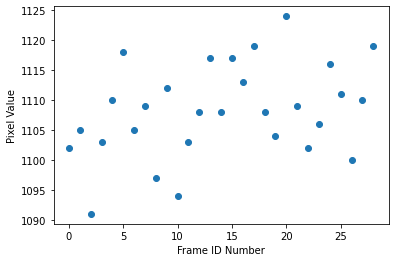

In [57]:
plt.plot(dark_timeseries[:,100,150], 'o')
_=plt.xlabel("Frame ID Number")
_=plt.ylabel("Pixel Value")

We calculate a noise image by taking the standard deviation in time:

In [58]:
dark_std = dark_timeseries.std(axis=0, ddof=1)
dark_mean = dark_timeseries.mean(axis=0)

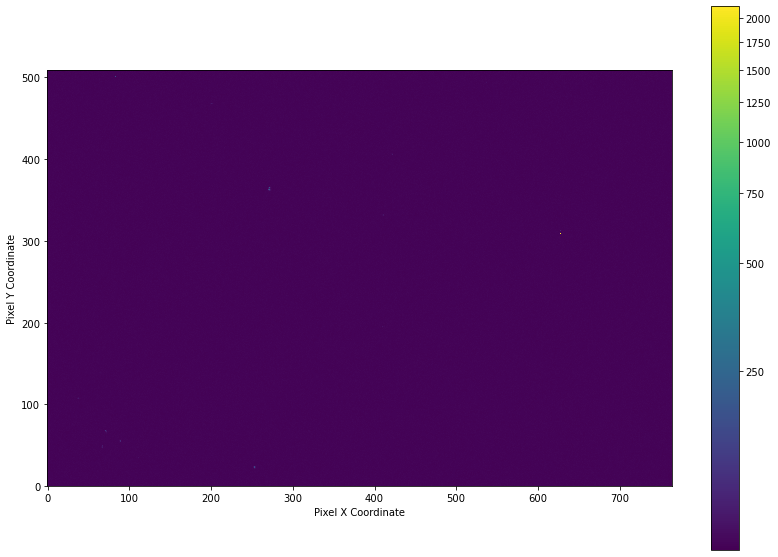

In [59]:
plt.figure(figsize=(14,10))
plt.imshow(dark_std, norm=visualization.simple_norm(dark_std, stretch='asinh'))
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

Our hot pixel is causing problems, so let's chop it out semi-automatically using a `percentile` cut.  By setting `max_percent=99.95` below, we set the brightest pixel in the displayed stretch to be just a little bit fainter than the brightest pixel.

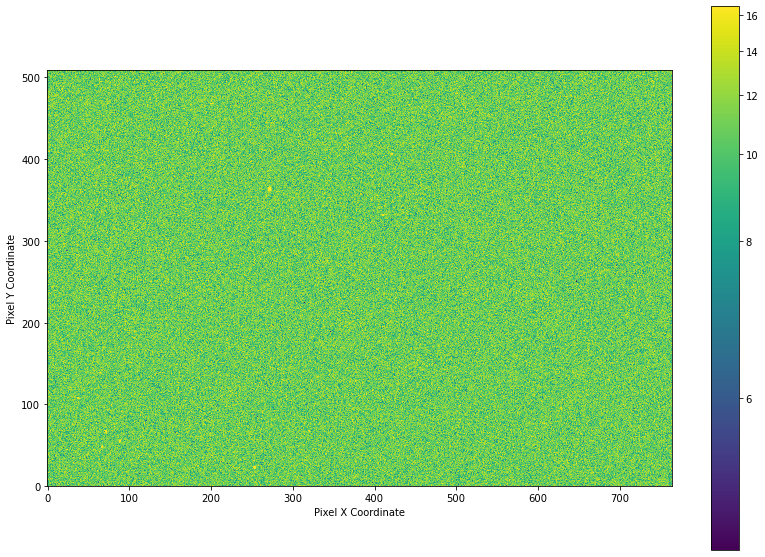

In [60]:
plt.figure(figsize=(14,10))
plt.imshow(dark_std, norm=visualization.simple_norm(dark_std, stretch='asinh', max_percent=99.95))
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

### Noise estimate from dark stack
[Index](#Index)


So again we have an image that contains (almost) only noise, but this time it contains contributions from both read noise and from dark current.


What are the mean and median noise level in this image?

In [61]:
# student exercise
mean_dark_noise = dark_std.mean()
median_dark_noise = np.median(dark_std)

In [62]:
print("Mean dark noise:",mean_dark_noise)
print("Median dark noise:",median_dark_noise)

Mean dark noise: 10.870688076255952
Median dark noise: 10.813465423710756


You should get values:

 * Mean dark noise: 10.870688076255952
 * Median dark noise: 10.813465423710756


We had 29 dark frames and 10 bias frames, so our estimate of the dark noise (from the dark frames) will be more precise than the readnoise estimate from the bias frames.  In the histogram below, the distribution will be narrower for the darks.

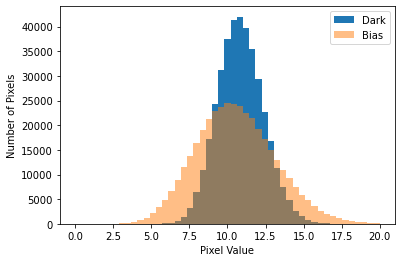

In [63]:
# comparison of the dark noise (note that this time we hand-specified the bin locations)
_ = plt.hist(dark_std.ravel(), bins=np.linspace(0,20), label='Dark')
_ = plt.hist(bias_std_image.ravel(), bins=np.linspace(0,20), label='Bias', alpha=0.5)
leg = plt.legend(loc='best')
_=plt.xlabel("Pixel Value")
_=plt.ylabel("Number of Pixels")

In [64]:
print("Mean read noise:",mean_readnoise)
print("Median read noise:",median_readnoise)

Mean read noise: 10.557842457849686
Median read noise: 10.429125882194858


Now we can estimate how much _noise_ was added by the dark current.

We know that the dark current added (dark_mean - bias_mean_image) counts:

In [65]:
mean_dark_current = np.mean(dark_mean) - np.mean(bias_mean_image)
mean_dark_current

13.815112984837924

What is the resulting dark rate?

In [66]:
# student exercise
dark_rate_estimate = mean_dark_current/10
dark_rate_estimate

1.3815112984837925

You should obtain ~1.39 counts/second

Given the dark rate you've estimated, let's assess whether the "bias" frames are really dark-electron-free.

How many dark current counts do you expect, on average, per pixel in the bias frames?

In [72]:
# student exercise
n_dark_counts = dark_rate_estimate*.04
n_dark_counts

0.0552604519393517

Based on that result, assess: Is the short "bias" exposure really a good estimate of the bias, or is it significantly affected by dark current?

Student answer:
-student answer-

# 3. Inspect some on-sky data

[Index](#Index)

There is one image file, `target_image.FIT`, that we'll inspect now.

First, display the image with reasonable contrast using what you've learned above.  

Recall that you can see help on a command by putting `<commandname>?` in a cell.  For example, you might do `visualization.simple_norm?` to see what the `simple_norm` function can do, or `plt.imshow?` to see what imshow can do.

In [69]:
# student exercise: load the file
target_image = 'target_image.FIT'

In [71]:
# student exercise: display the data so you can see what's going on
data = fits.getdata(target_image)
data

array([[1222, 1275, 1261, ..., 1234, 1217, 1196],
       [1278, 1250, 1276, ..., 1199, 1210, 1233],
       [1256, 1311, 1240, ..., 1205, 1183, 1216],
       ...,
       [1274, 1273, 1292, ..., 1211, 1233, 1203],
       [1268, 1281, 1277, ..., 1215, 1196, 1213],
       [1263, 1289, 1255, ..., 1203, 1201, 1229]], dtype=uint16)

You should note that there are still artifacts similar to those we saw earlier.  So, now we will subtract the dark frame from the image.  You have an average dark frame built from the average of many 10s darks.  Use that!

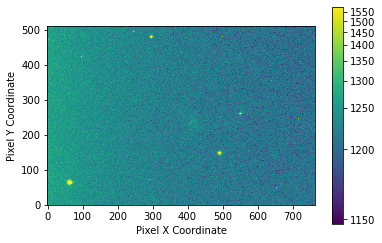

In [75]:
# student exercise: make a dark-subtracted version of the above
plt.imshow(data, norm=visualization.simple_norm(data, stretch='asinh', max_percent=99.95))
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

In [80]:
# student exercise: display the dark subtracted data
dark_target_image = data - dark_mean
dark_target_image

array([[ 83.55172414, 135.51724138, 123.75862069, ..., 158.24137931,
        138.62068966, 119.79310345],
       [139.24137931, 113.75862069, 139.89655172, ..., 121.51724138,
        132.96551724, 152.51724138],
       [119.20689655, 171.82758621, 103.75862069, ..., 127.31034483,
        109.03448276, 134.89655172],
       ...,
       [140.31034483, 136.75862069, 157.24137931, ..., 133.31034483,
        158.48275862, 125.03448276],
       [130.34482759, 142.96551724, 138.17241379, ..., 137.37931034,
        118.55172414, 135.48275862],
       [122.68965517, 152.20689655, 120.24137931, ..., 128.68965517,
        125.96551724, 153.93103448]])

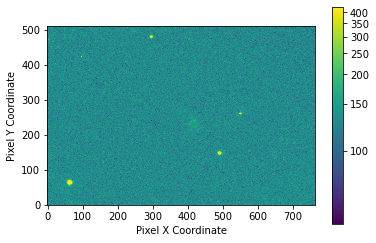

In [78]:
plt.imshow(dark_target_image, norm=visualization.simple_norm(dark_target_image, stretch='asinh', max_percent=99.95))
plt.colorbar()
_=plt.xlabel("Pixel X Coordinate")
_=plt.ylabel("Pixel Y Coordinate")

What do you think?  Did dark subtraction improve the image?  How?

<student answer>

# Index (end)


 * [#1. Inspect Biases](#1.-Inspect-an-image:-Bias) - mostly guided work, you will run cells & read
   * [Show an image with improved contrast](#Show-an-image-with-improved-contrast)
   * [Zoom in on a hot pixel](#Zooming-in-on-a-hot-pixel) student exercise
   * [Examining Histograms](#Examining-Histograms)
   * [Masking](#Masking)
   * [Gaussian Distribution](#Gaussian-distribution)
   * [Noise Estimation](#Noise-Estimation)
   * [Header Loading](#Header-Loading-Aside) student exercise
   * [Multiple Exposures -> Time Series Cube](#Multiple-Exposures-as-a-"Time-Series"-Data-Cube)
   * [Mean of the Mean](#The-mean-of-the-mean)
   * [Robust Statistics](#Robust-Statistics)
 * [#2. Inspect Darks](#2.-Inspect-an-image:-Dark-Frame) - student work: you fill in the blanks
   * [Dark Frame Questions](#Dark-Frame-Questions)
   * [Dark Current Rate](#Dark-Current-Rate)
   * [vmin, vmax](#Student-Question:-vmin,-vmax)
   * [Bias-subtracted dark statistics](#Bias-subtracted-Dark-Stats)
   * [Noise estimate from dark stack](#Noise-estimate-from-dark-stack)
 * [#3. Image Inspection](#3.-Inspect-some-on-sky-data)